# Test technique Equancy de Théophile Ravillion 

In [96]:
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from gensim.models import LdaModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer 

sns.set_palette("bright")

1) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs
manquantes ? 

In [2]:
# Load data
df = pd.read_csv('data.csv')

print(f"Le dataset contient {df.shape[0]} observations.")

print("Il y a des valeurs manquantes dans le dataset :\n", df.isnull().sum())

Le dataset contient 9582 observations.
Il y a des valeurs manquantes dans le dataset :
 Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64


2. Réaliser l'imputation des valeurs manquantes pour la variable "Experience"  

In [3]:
# Experience column should be a float
df.Experience = df.Experience.apply(lambda x: float(str(x).replace(',','.')))

# fill DS and DE with mean and median
for metier, strategy in zip(['Data scientist', 'Data engineer'], ['mean', 'median']):
    imputer = SimpleImputer(strategy=strategy)

    # get rows 
    df_metier = df.query(f'Metier == "{metier}"').Experience.values.reshape(-1, 1)

    # fill missing values 
    df.loc[df['Metier'] == metier, 'Experience'] = imputer.fit_transform(df_metier)

 

3.Combien d'années d'expériences ont, en moyenne, chacun des profils : le
data scientist, le lead data scientist et le data engineer en moyenne ? 

In [4]:
# compute average experience by job
df.groupby(['Metier'])['Experience'].mean().reset_index()

Metier  Experience
0      Data architecte    3.000476
1        Data engineer    2.980827
2       Data scientist    2.243282
3  Lead data scientist    3.965261

4. Faire la représentation graphique de votre choix afin de comparer le
nombre moyen d'années d'expériences pour chaque métier

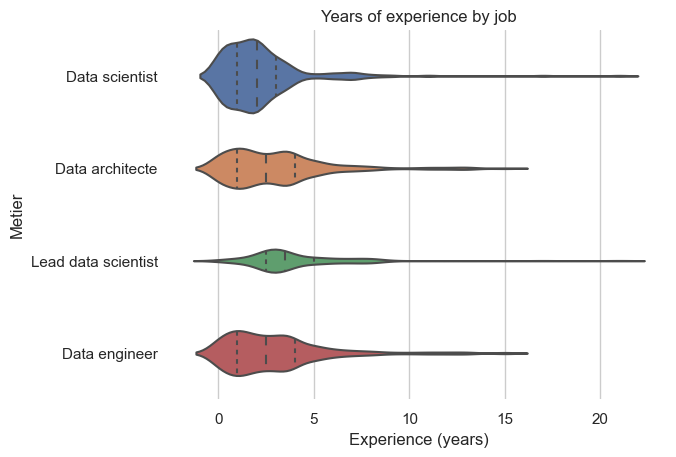

In [5]:
# Display Experience by job with violinplot
sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=df.rename(columns={'Experience':'Experience (years)'}), y="Metier", x="Experience (years)", inner="quart", scale='count')
ax.set(title='Years of experience by job')
sns.despine(left=True, bottom=True)
plt.show()

5. Transformer la variable continue 'Experience' en une nouvelle variable
catégorielle 'Exp_label' à 4 modalités : débutant, confirmé, avancé et expert.
Veuillez expliquer votre choix de la règle de transformation.<br><br>
**Réponse** : <br>
Je choisis pour chaque métier de calculer d'associer chacune des modalité en fonction du quartile du métier.
Ceci permet de conserver un maximum d'information sur la variable d'origine tout en ayant une mécanique simple et des seuils adaptés à chaque profession.

In [6]:
labels = ['débutant', 'confirmé', 'avancé', 'expert']

# For each job, we get the label corresponding to the quartile
for metier in df.Metier.dropna().unique():
    df.loc[df['Metier'] == metier, 'Exp_label'] = pd.qcut(df.query(f'Metier == "{metier}"').Experience, 4, labels = labels)

6. Quelles sont les 5 technologies les plus utilisées ? Faites un graphique

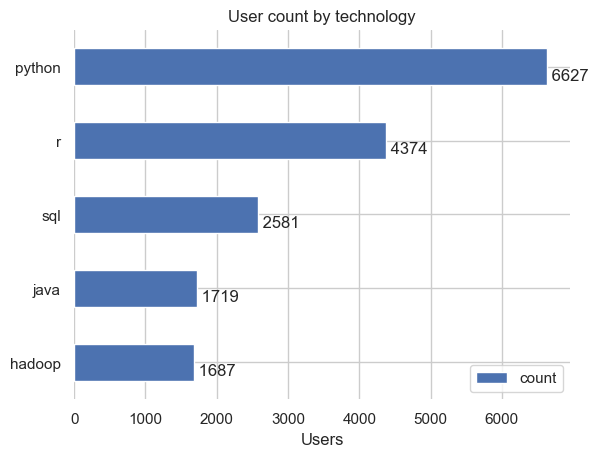

In [7]:
def clean_case(lst): 
    return [x.lower().replace(' ', '_') for x in lst.split('/')]
 
def remove_duplicates(lst):
    synonyms ={'hadoop(hdfs)': 'hadoop', 'nosq': 'nosql', 'ai': 'machine_learning'}
    return list(set([tech if tech not in synonyms else synonyms[tech] for tech in lst]))

def remove_empty_elements(lst):
    return [element for element in lst if element != ''] 

df['Technologies'] = df['Technologies'].apply(clean_case).apply(remove_duplicates).apply(remove_empty_elements)

# count users by technology 
technologies = df['Technologies'].explode().value_counts()

# display it as a graph
ax = technologies.head(5).sort_values().plot(kind='barh')
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="",xlabel="Users", title="User count by technology")
sns.despine(left=True, bottom=True)
ax.bar_label(ax.containers[-1], fmt='\n %.0f', label_type='edge')
plt.show()

In [8]:
# list all the technologies
technologies = df['Technologies'].explode().sort_values().unique()
print(f'Voici la liste des {len(technologies)} technologies considérées : \n\n {technologies}')

Voici la liste des 53 technologies considérées : 

 ['anglais' 'aws' 'big_data' 'c' 'c++' 'cassandra' 'deep_learning' 'docker'
 'elasticsearch' 'excel' 'gnu' 'hadoop' 'hbase' 'hdfs' 'hive' 'java'
 'kafka' 'kibana' 'linux' 'machine_learning' 'map-reduce' 'mariadb'
 'matlab' 'matplotlib' 'microsoft_azure' 'mongodb' 'mysql' 'nosql' 'numpy'
 'oracle' 'perl' 'pig' 'postgresql' 'pycharm' 'pyspark' 'python' 'r'
 'redshift' 'ruby' 'sas' 'scala' 'scikit-learn' 'scoring' 'spark' 'spss'
 'sql' 'tableau' 'tensorflow' 'teradata' 'vba' 'vertica' 'windows' 'yarn']


**7. Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître le nombre de clusters que vous jugerez pertinents.**<br>
Donnez les caractéristiques de chacun des clusters.<br>
a. Justifier le nombre de clusters<br>
b. Justifier la performance de votre algorithme grâce à une métrique.<br>

<br>
**Réponse** : <br>
Ma démarche est ici de ne segmenter mes utilisateurs que sur la base des technologies qu'ils utilisent. Les autres variables serviront à décrire ces clusters. <br>
L'ambition est de décrire plus efficacement la stack technique de chacune des personnes du dataset qu'avec l'actuelle liste de technologies.
<br> Je vais comparer ici deux algorithmes qui se prêtent bien à la situation "Latent Dirichlet Allocation" et "Non-negative Matrix Factorization" qui s'y prète bien dans la mesure où :
- Nous avons des données textuelles.
- Un soft clustering convient bien. On peut imaginer par exemple qu'une personne soit taguée sur deux stacks.
- Le nombre important (cinquante sept) de technologies différentes qui pose un problème de dimension pour des algoritmes plus classiques (K-mean, DB-scan, etc)
<br>

Pour évaluer la pertinence de nos modèles et du nombre de clusters, nous utiliserons : 
- La métrique "Silhouette Score" qui qualifie la bonne séparation de nos clusters
- La métrique "Adjusted Mutual Information" calculée sur le métier. Nous considèrerons en effet qu'une segmentation qui fait bien ressortir les différents métiers de la data est une bonne segmentation.

## 7. Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître le nombre de clusters que vous jugerez pertinents.
Donnez les caractéristiques de chacun des clusters.
- a. Justifier le nombre de clusters
- b. Justifier la performance de votre algorithme grâce à une métrique.

<br>

## Réponse : 

Ma démarche est ici de ne segmenter mes utilisateurs que sur la base des technologies qu'ils utilisent. Les autres variables serviront à décrire ces clusters. L'ambition est de décrire plus efficacement la stack technique de chacune des personnes du dataset qu'avec l'actuelle liste de technologies.

Je vais comparer ici deux algorithmes qui se prêtent bien à la situation "Latent Dirichlet Allocation" et "Non-negative Matrix Factorization" qui s'y prète bien dans la mesure où :
- Nous avons des données textuelles.
- Un soft clustering convient bien. On peut imaginer par exemple qu'une personne soit taguée sur deux stacks.
- Le nombre important (cinquante sept) de technologies différentes qui pose un problème de dimension pour des algoritmes plus classiques (K-mean, DB-scan, etc)

Pour évaluer la pertinence de nos modèles et du nombre de clusters, nous utiliserons : 
- La métrique "Silhouette Score" qui qualifie la bonne séparation de nos clusters
- La métrique "Adjusted Mutual Information" calculée sur le métier. Nous considèrerons en effet qu'une segmentation qui fait bien ressortir les différents métiers de la data est une bonne segmentation.


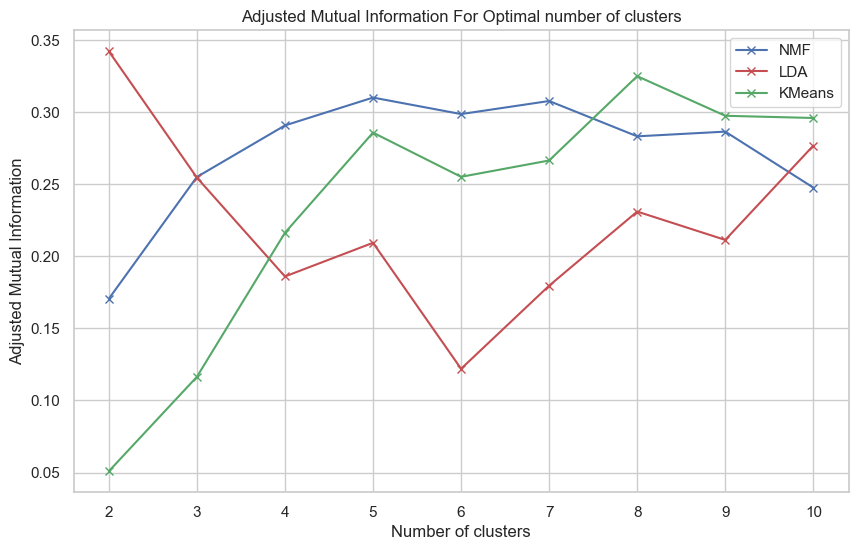

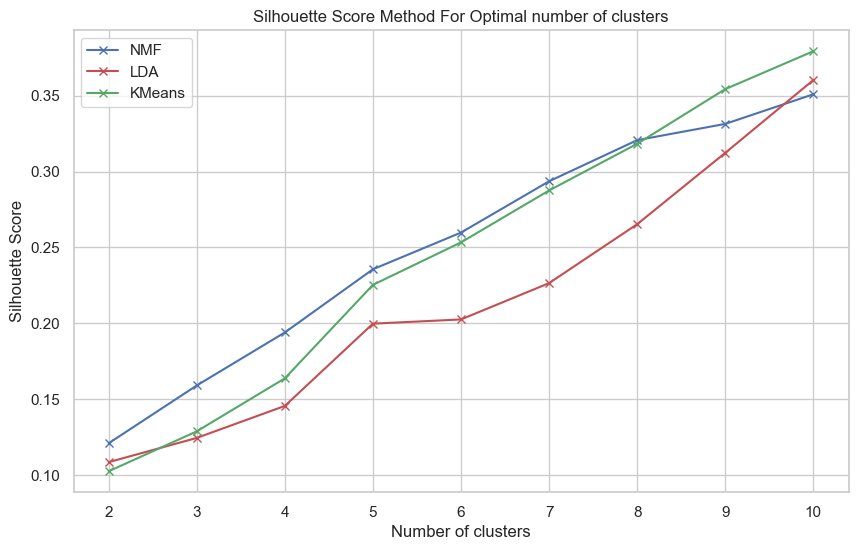

In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.cluster import KMeans

# To store the values for each metric for KMeans
silhouette_scores_kmeans = []
ami_scores_kmeans = []

df['Technologies_str'] = df['Technologies'].apply(lambda x: ' '.join(x))

# Transform the list of technologies to a TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Technologies_str'])

# Values to try for n_clusters
clusters_range = range(2, 11)

# To store the values for each metric for NMF
silhouette_scores_nmf = []
ami_scores_nmf = []

# To store the values for each metric for LDA
silhouette_scores_lda = []
ami_scores_lda = []

# To store the values for each metric for KMeans
silhouette_scores_kmeans = []
ami_scores_kmeans = []

for n_clusters in clusters_range:
    # Fit the NMF model
    nmf = NMF(n_components=n_clusters, random_state=0)
    W_nmf = nmf.fit_transform(X)

    # Fit the LDA model
    lda = LatentDirichletAllocation(n_components=n_clusters, random_state=0)
    W_lda = lda.fit_transform(X)
    
    # Fit the KMeans model
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    kmeans.fit(X.toarray()) 

    # Get the cluster assignments
    cluster_assignments_nmf = W_nmf.argmax(axis=1)
    cluster_assignments_lda = W_lda.argmax(axis=1)
    cluster_assignments_kmeans = kmeans.labels_

    # Silhouette Score
    silhouette_avg_nmf = silhouette_score(X, cluster_assignments_nmf)
    silhouette_scores_nmf.append(silhouette_avg_nmf) 
    
    silhouette_avg_lda = silhouette_score(X, cluster_assignments_lda)
    silhouette_scores_lda.append(silhouette_avg_lda)
    
    silhouette_avg_kmeans = silhouette_score(X, cluster_assignments_kmeans)
    silhouette_scores_kmeans.append(silhouette_avg_kmeans) 

    # Adjusted Mutual Information
    ami_score_nmf = adjusted_mutual_info_score(df['Metier'].fillna('Data scientist'), cluster_assignments_nmf)
    ami_scores_nmf.append(ami_score_nmf)
    
    ami_score_lda = adjusted_mutual_info_score(df['Metier'].fillna('Data scientist'), cluster_assignments_lda)
    ami_scores_lda.append(ami_score_lda)
    
    ami_score_kmeans = adjusted_mutual_info_score(df['Metier'].fillna('Data scientist'), cluster_assignments_kmeans)
    ami_scores_kmeans.append(ami_score_kmeans)

# Plot Adjusted Mutual Information scores
plt.figure(figsize=(10,6))
plt.plot(clusters_range, ami_scores_nmf, 'bx-', label='NMF')
plt.plot(clusters_range, ami_scores_lda, 'rx-', label='LDA')
plt.plot(clusters_range, ami_scores_kmeans, 'gx-', label='KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted Mutual Information')
plt.title('Adjusted Mutual Information For Optimal number of clusters')
plt.legend()
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10,6))
plt.plot(clusters_range, silhouette_scores_nmf, 'bx-', label='NMF')
plt.plot(clusters_range, silhouette_scores_lda, 'rx-', label='LDA')
plt.plot(clusters_range, silhouette_scores_kmeans, 'gx-', label='KMeans')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method For Optimal number of clusters')
plt.legend()
plt.show()


#### **Décisions :**
- NMF performe mieux que LDA et KMeans sur cet excercice pour un faible nombre de clusters. Nous retenons donc cet algorithme. 
- Sur la base de l'AMI, nous prendrons 5 clusters.

In [10]:
# Transform the list of technologies to a TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Technologies_str'])

# Fit the NMF model
nmf = NMF(n_components=5, random_state=0)  # Set the number of clusters you want
W = nmf.fit_transform(X)
H = nmf.components_

# Assign the cluster to each person
df['Cluster'] = W.argmax(axis=1)

df.groupby('Cluster').describe(include='all').dropna(axis=1)['Technologies', 'top']

df['Cluster_str'] = df['Cluster'].apply(lambda x: str(x))

In [11]:
cluster_name_dic = {'0':'1 Data Science Académique', '1':'2 Data Science Business', '2':'3 Développeurs data', '3':'4 Ingénieurs en Big Data', '4':'5 Ingénieurs DevOps pour la Data'}
df['Segment'] = df['Cluster_str'].map(cluster_name_dic)

In [12]:
df_stats = df.groupby('Segment')['Metier'].value_counts().unstack() / df.shape[0] *100
df_stats['technologies used'] = df.groupby('Cluster').describe(include='all').dropna(axis=1)['Technologies', 'top'].apply(lambda x: ' '.join(x)).values
df_stats['Experience average'] = df[['Cluster', 'Experience']].groupby('Cluster').mean().Experience.values
df_stats.reset_index().fillna(0)

Metier                           Segment  Data architecte  Data engineer  \
0              1 Data Science Académique         0.000000       0.000000   
1                2 Data Science Business         0.000000       0.000000   
2                    3 Développeurs data         6.115633      12.335629   
3               4 Ingénieurs en Big Data         7.628887       6.470465   
4       5 Ingénieurs DevOps pour la Data         8.411605       5.687748   

Metier  Data scientist  Lead data scientist  \
0            16.718848             4.957211   
1            15.977875             4.831977   
2             2.254227             0.480067   
3             4.560635             2.295972   
4             0.824463             0.250470   

Metier                                  technologies used  Experience average  
0                                   sql r python big_data            2.541748  
1       machine_learning sql anglais sas teradata r py...            2.703435  
2                                       c++ java python c            2.901916  
3                             hive hadoop tableau vertica            2.997864  
4          docker elasticsearch postgresql mongodb kibana            2.962707

In [13]:
df_stats.reset_index().fillna(0)[['Segment', 'Data architecte', 'Data engineer', 'Data scientist',
       'Lead data scientist', 'technologies used', 'Experience average']]

Metier                           Segment  Data architecte  Data engineer  \
0              1 Data Science Académique         0.000000       0.000000   
1                2 Data Science Business         0.000000       0.000000   
2                    3 Développeurs data         6.115633      12.335629   
3               4 Ingénieurs en Big Data         7.628887       6.470465   
4       5 Ingénieurs DevOps pour la Data         8.411605       5.687748   

Metier  Data scientist  Lead data scientist  \
0            16.718848             4.957211   
1            15.977875             4.831977   
2             2.254227             0.480067   
3             4.560635             2.295972   
4             0.824463             0.250470   

Metier                                  technologies used  Experience average  
0                                   sql r python big_data            2.541748  
1       machine_learning sql anglais sas teradata r py...            2.703435  
2                                       c++ java python c            2.901916  
3                             hive hadoop tableau vertica            2.997864  
4          docker elasticsearch postgresql mongodb kibana            2.962707


#### **Interprétation des clusters :**

Cluster 1 : "Data Science Académique" <br>
Ce groupe est constitué uniquement de Data Scientists et de Lead Data Scientists avec une forte expertise en R, Python, Big Data et SQL. Ils ont relativement peu d'années d'expérience totale. Comme indiqué par le nom du cluster, il s'agit de personnes ayant une formation académique solide.

Cluster 2 : "Data Science Business" <br>
Ce cluster est également composé uniquement de Data Scientists et de Lead Data Scientists. Ils sont compétents en Teradata, R, Python, Machine Learning, Anglais et SAS, et sont un peu plus expérimentés que leur condisciples académiques. Ils sont plus orientés vers l'application de la data science aux problèmes business et sont plus orientés analyses de données.

Cluster 3 : "Développeurs data" <br>
Ce groupe se compose principalement de Data Engineers et de Data Architects avec des compétences en Python, C++, Java et C. Ils ont en moyenne environ 2.9 années d'expérience. Leur profil suggère qu'ils sont fortement impliqués dans la programmation orienté objet.

Cluster 4 : "Ingénieurs en Big Data" <br>
Ce groupe est majoritairement constitué deData Architects, Data Engineers et Data Scientists avec des compétences en Hive, Tableau, Hadoop et Vertica. Ils sont tendanciellement plus experimentés que les autres segments et sont  spécialisés dans le traitement et l'analyse de grands ensembles de données.

Cluster 5 : "Ingénieurs DevOps pour la Data" <br>
Ce groupe se compose principalement de Data Engineers et de Data Architects avec une expertise en MongoDB, Docker, Kibana, Elasticsearch et PostgreSQL. Ils ont en moyenne environ 2.96 années d'expérience. Leur profil indique qu'ils sont impliqués dans les opérations de développement et de gestion des infrastructures de données.

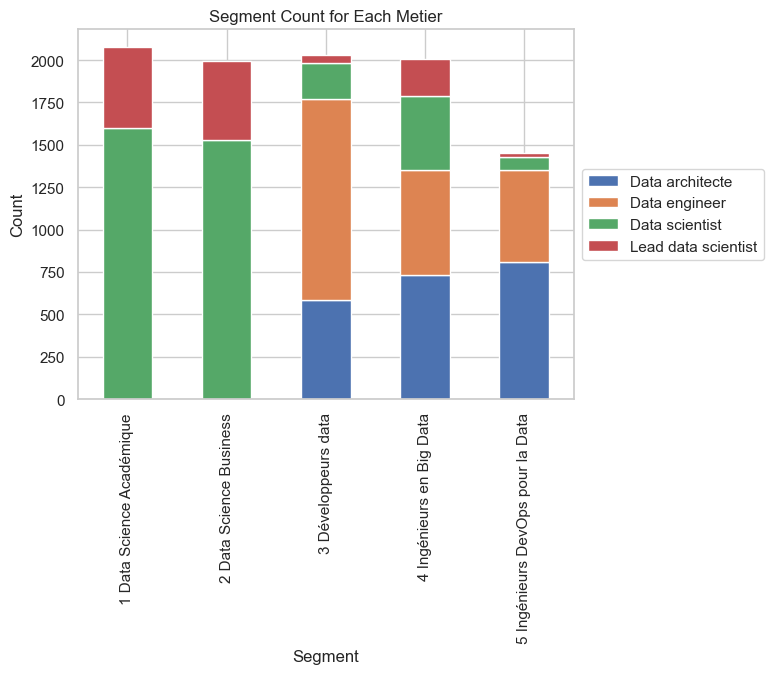

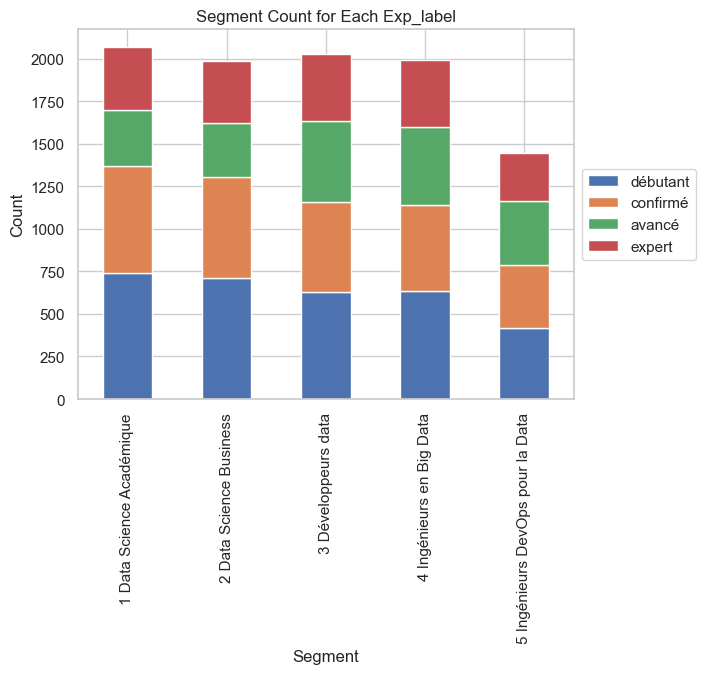

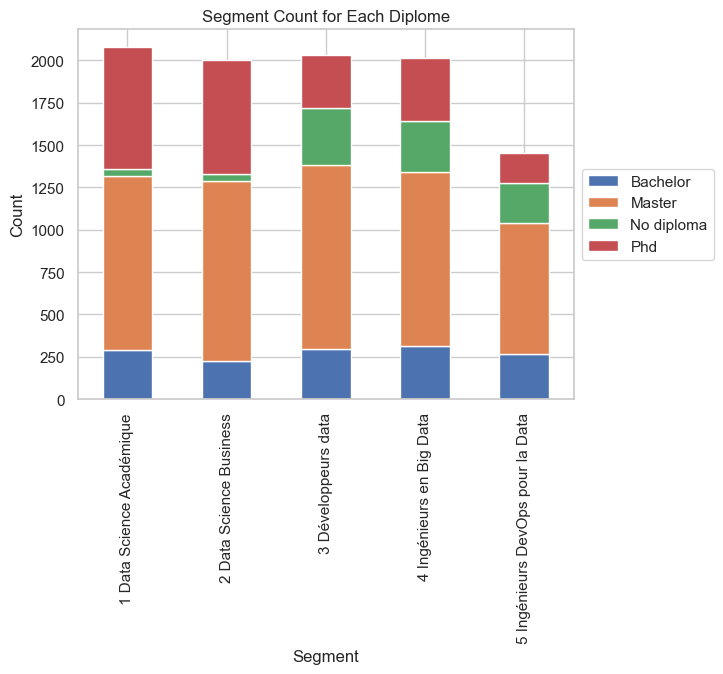

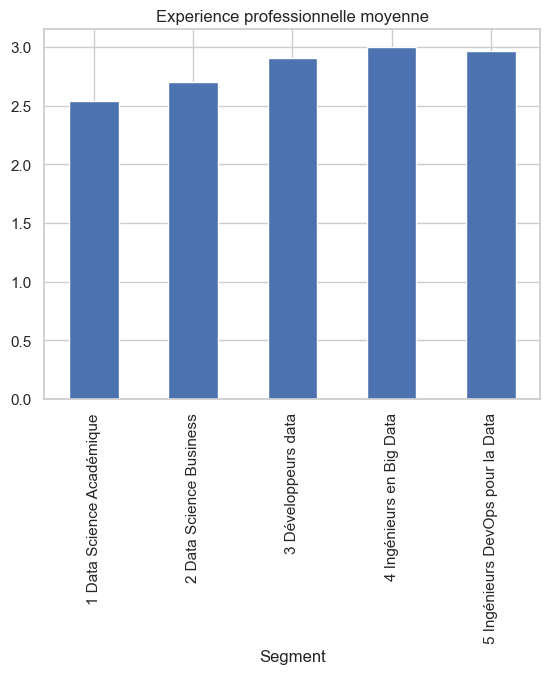

In [14]:
cluster_counts = df.groupby('Segment')['Metier'].value_counts().unstack()
# Create a stacked bar chart
ax1 = cluster_counts.plot(kind='bar', stacked=True )
plt.title('Segment Count for Each Metier')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
 
cluster_counts = df.groupby('Segment')['Exp_label'].value_counts().unstack()
# Create a stacked bar chart
ax2 = cluster_counts.plot(kind='bar', stacked=True )
plt.title('Segment Count for Each Exp_label')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
 
cluster_counts = df.groupby('Segment')['Diplome'].value_counts().unstack()
# Create a stacked bar chart
ax3 = cluster_counts.plot(kind='bar', stacked=True )
plt.title('Segment Count for Each Diplome')
plt.xlabel('Segment')
plt.ylabel('Count')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

df.groupby('Segment')['Experience'].mean().plot.bar(title='Experience professionnelle moyenne')
plt.show() 


## 8) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
- Justifier la performance de votre algorithme grâce à une métrique.
- Interpréter votre résultat <br>
**Réponse : J'utiliserai ici l'accuracy pour comparer les modèles entre eux puis un rapport complet pour comprendre la performance du modèle final**

0:	learn: 1.3024087	test: 1.3001288	best: 1.3001288 (0)	total: 9.54ms	remaining: 4.76s
50:	learn: 0.7826004	test: 0.7474212	best: 0.7474212 (50)	total: 1.19s	remaining: 10.4s
100:	learn: 0.7574027	test: 0.7138004	best: 0.7138004 (100)	total: 2.33s	remaining: 9.21s
150:	learn: 0.7430294	test: 0.6991284	best: 0.6991284 (150)	total: 3.47s	remaining: 8.03s
200:	learn: 0.7333085	test: 0.6911200	best: 0.6911200 (200)	total: 5.03s	remaining: 7.48s
250:	learn: 0.7248022	test: 0.6861664	best: 0.6861664 (250)	total: 7.93s	remaining: 7.87s
300:	learn: 0.7166629	test: 0.6832678	best: 0.6832678 (300)	total: 10.5s	remaining: 6.92s
350:	learn: 0.7083512	test: 0.6790486	best: 0.6790486 (350)	total: 13.3s	remaining: 5.65s
400:	learn: 0.7001127	test: 0.6762898	best: 0.6761275 (399)	total: 15.7s	remaining: 3.87s
450:	learn: 0.6923430	test: 0.6747871	best: 0.6746169 (438)	total: 18s	remaining: 1.96s
499:	learn: 0.6846448	test: 0.6740932	best: 0.6739897 (497)	total: 20.3s	remaining: 0us

bestTest = 0.67398

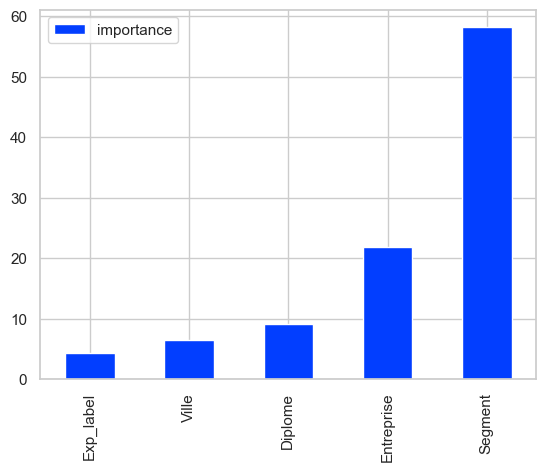

In [119]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

features = ['Entreprise', 'Diplome', 'Exp_label', 'Ville', 'Segment']
data = df.copy()[features + ['Metier']]

# Define the imputer
imputer = SimpleImputer(strategy='most_frequent') 

for feature in features:
    data[feature] = imputer.fit_transform(data[[feature]]).reshape(-1)

data_notnull = data[~data.Metier.isna()]

X, y = data_notnull[features], data_notnull['Metier']
    
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Instantiate model
model = CatBoostClassifier(loss_function='MultiClass', cat_features=features, iterations=500, learning_rate=0.1, depth=4, verbose=50)

# Fit model
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Make predictions and evaluate the classifier
y_val_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred)) 

pd.DataFrame(model.feature_importances_, index=features, columns=['importance']).sort_values('importance').plot.bar()
plt.show()



**Optimisations**
- L'importance des variables est très hétérogène : 
- "Segmentation" semble déterminante et nous allons donc créer une deuxième feature de segmentation avec k-mean en utilisant un nombre plus élevé de clusters.<br>
- "Exp_label" n'apporte pas beaucoup d'information mais le modèle semble confondre data scientist et lead data scientist. Nous changeons donc cette feature pour "Experience", la valeur entière non bucketisée.

0:	learn: 1.2866111	test: 1.2832955	best: 1.2832955 (0)	total: 17ms	remaining: 17s
50:	learn: 0.7314807	test: 0.7011963	best: 0.7011963 (50)	total: 880ms	remaining: 16.4s
100:	learn: 0.6972367	test: 0.6570010	best: 0.6570010 (100)	total: 1.73s	remaining: 15.4s
150:	learn: 0.6827912	test: 0.6390858	best: 0.6390858 (150)	total: 2.56s	remaining: 14.4s
200:	learn: 0.6750336	test: 0.6317059	best: 0.6317059 (200)	total: 3.4s	remaining: 13.5s
250:	learn: 0.6684904	test: 0.6270090	best: 0.6269705 (249)	total: 4.3s	remaining: 12.8s
300:	learn: 0.6628163	test: 0.6222835	best: 0.6222835 (300)	total: 5.47s	remaining: 12.7s
350:	learn: 0.6582805	test: 0.6182606	best: 0.6182606 (350)	total: 7.35s	remaining: 13.6s
400:	learn: 0.6533764	test: 0.6154784	best: 0.6154784 (400)	total: 9.46s	remaining: 14.1s
450:	learn: 0.6490529	test: 0.6128385	best: 0.6128203 (449)	total: 12s	remaining: 14.6s
500:	learn: 0.6451874	test: 0.6104698	best: 0.6104698 (500)	total: 14.2s	remaining: 14.1s
550:	learn: 0.6416462	t

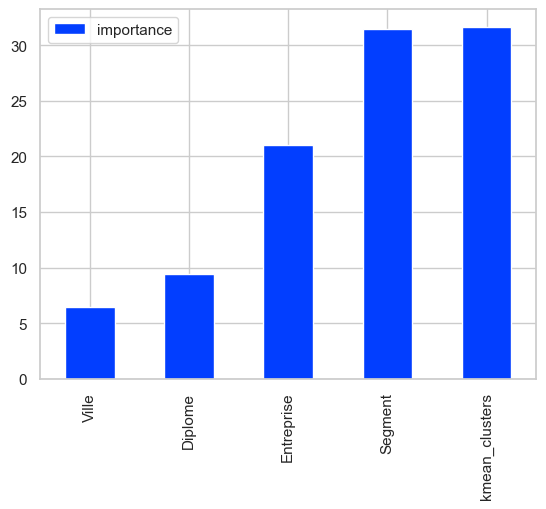

In [123]:
# Transform the list of technologies to a TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Technologies_str'])

# Values to try for n_clusters
clusters_range = range(2, 11)

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
kmeans.fit(X.toarray()) 

# add the feature
data['kmean_clusters'] = kmeans.labels_
data['Experience'] = df.Experience.fillna(0).apply(int)
features = ['Entreprise', 'Diplome', 'Ville', 'Segment', 'kmean_clusters', 'Experience']

# we use only the data where metier is known
data_notnull = data[~data.Metier.isna()]

# instantiate x and y
X, y = data_notnull[features], data_notnull['Metier']
    
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

# Instantiate model
model = CatBoostClassifier(loss_function='MultiClass', cat_features=features, iterations=1000, learning_rate=0.1, depth=3, verbose=50)

# Fit model
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Make predictions and evaluate the classifier
y_val_pred = model.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred)) 

pd.DataFrame(model.feature_importances_, index=features, columns=['importance']).sort_values('importance').plot.bar()
plt.show()


**Nous avons maintenant une accuracy de : 0.748 ce qui parait acceptable. Prédisons les valeurs manquantes**

In [145]:
# we use only the data where metier is known
data_null = data[data.Metier.isna()]

# instantiate x and y
X = data_null[features]  

# Make predictions and evaluate the classifier
data_null['Metier'] = [x[0] for x in model.predict(X)]

# Lets visualise our predictions :
data_null

Entreprise     Diplome Exp_label      Ville  \
346                       Jacobs  No diploma  débutant      Paris   
2058              Ball Aerospace      Master  débutant       Lyon   
2670                  eHire, LLC      Master  débutant   Toulouse   
2899       Norfolk Southern Corp         Phd  débutant   Grenoble   
3346       J.E. Ranta Associates      Master  débutant     Rennes   
4248                        KPMG         Phd  débutant       Lyon   
4290         Pandora Media, Inc.         Phd  débutant   Toulouse   
4292    Partners HealthCare(PHS)      Master  débutant   Bordeaux   
5425           Ashton Lane Group  No diploma  débutant       Lyon   
5593     Lighthouse Lab Services      Master  débutant       Lyon   
5712              Ball Aerospace    Bachelor  débutant      Paris   
6024                      Leidos      Master  débutant       Lyon   
6625              Ball Aerospace  No diploma  débutant      Paris   
7091                        KPMG      Master  débutant  Marseille   
7228  Environmental Defense Fund      Master  débutant   Bordeaux   
7330                      Turner         Phd  débutant       Lyon   
9087   Klein Hersh International  No diploma  débutant      Paris   
9427          McKinsey & Company      Master  débutant  Marseille   
9490                     Pearson      Master  débutant  Marseille   

                               Segment               Metier  kmean_clusters  \
346                3 Développeurs data        Data engineer               8   
2058           2 Data Science Business  Lead data scientist               5   
2670               3 Développeurs data        Data engineer               1   
2899         1 Data Science Académique       Data scientist               3   
3346  5 Ingénieurs DevOps pour la Data      Data architecte               0   
4248         1 Data Science Académique       Data scientist               4   
4290           2 Data Science Business       Data scientist               9   
4292           2 Data Science Business  Lead data scientist               9   
5425          4 Ingénieurs en Big Data        Data engineer               8   
5593           2 Data Science Business  Lead data scientist               5   
5712          4 Ingénieurs en Big Data      Data architecte               2   
6024               3 Développeurs data        Data engineer               1   
6625          4 Ingénieurs en Big Data      Data architecte               2   
7091           2 Data Science Business       Data scientist               9   
7228               3 Développeurs data        Data engineer               1   
7330           2 Data Science Business       Data scientist               5   
9087          4 Ingénieurs en Big Data      Data architecte               2   
9427           2 Data Science Business       Data scientist               5   
9490          4 Ingénieurs en Big Data        Data engineer               8   

      Experience  
346            2  
2058          15  
2670           1  
2899           0  
3346           7  
4248           2  
4290           1  
4292           8  
5425           5  
5593           3  
5712           3  
6024           1  
6625           0  
7091           0  
7228           2  
7330           0  
9087           3  
9427           1  
9490           4